In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(RCurl)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

## Introduction

Auditing is a critical process that protects the financial interests of a certain company. Auditing firms examine various documents and books of accounts to avoid fraudulent behaviour and errors in general. Auditors confirm that companies are lawfully orchestrating their business transactions through a series of interviews and record checks. They produce and share their findings with the company and expect an action plan from the company moving forward. To analyze a company’s records, classification methods using R can predict if a company is likely fraudulent or not. The dataset used is a multivariate dataset with audit data from 777 firms during 2015 to 2016. This data can help answer the question: Is inherent risk a good predictor in predicting fraudulent behaviour of a company?

Below is what I wrote for the previous methods. You can add it to the introduction if you find it's helpful.
    
Risk is a class assigned to audit cases, which in the dataset represents whether a company is fraudulent using dummy/binary variable. (0 means not fraudulent; 1 means fraudulent). The goal of the project is to assist the auditors by developing a classification model to determine/predict whether a company is fraudulent or not based on the previous risk factors. To conclude, for this project, Score will be employed as the predictor to determine the fraudulent company, a categorical label.

## Preliminary exploratory data analysis

In [2]:
audit_risk<- read.csv("https://raw.githubusercontent.com/RofiaChen555/dsci-100-group-project/main/data/audit_risk.csv")
audit_risk

risk_dataset <- select(audit_risk, Score, Money_Value, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk, Risk)|>
            mutate(Risk = as_factor(Risk))
            
risk_dataset <- tibble::rowid_to_column(risk_dataset, "ID")
            
risk_dataset

Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,0
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,0
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,0


ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2.4,3.38,8.574,0.4,0.5,1.7148,1
2,2.0,0.94,2.554,0.4,0.5,0.5108,0
3,2.0,0.00,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
774,2,0.00,1.456,0.4,0.5,0.2912,0
775,2,0.00,1.440,0.4,0.5,0.2880,0
776,2,0.32,1.464,0.4,0.5,0.2928,0


In [3]:
set.seed(2022)
audit_risk_split <- initial_split(risk_dataset, prop = 0.75, strata = Risk)
audit_risk_train <- training(audit_risk_split)|>
                filter(!is.na(Money_Value))
audit_risk_test <- testing(audit_risk_split)|>
                filter(!is.na(Money_Value))

ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,2,0.94,2.554,0.4,0.5,0.5108,0
5,2,0.00,1.416,0.4,0.5,0.2832,0
6,2,2.95,2.156,0.4,0.5,0.4312,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
717,2.4,0.00,2.20,1.2,0.5,1.320,1
718,2.6,0.90,2.93,1.2,0.5,1.758,1
725,3.2,0.43,6.58,0.4,0.5,1.316,1


[1] 580

Risk,n,precentage
<fct>,<int>,<dbl>
0,352,60.68966
1,228,39.31034


Risk,mean_sc,mean_mv,mean_ir,mean_cr,mean_dr,mean_ar
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2.165341,0.3237045,1.955603,0.4227273,0.5,0.413874
1,3.543860,37.5088596,44.045684,0.8122807,0.5,18.964269


mv_min,mv_max
<dbl>,<dbl>
0,935.03


ir_min,ir_max
<dbl>,<dbl>
1.4,801.262


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 14 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 6 rows containing missing values (geom_bar).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 5 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 4 rows containing missing values (geom_bar).”


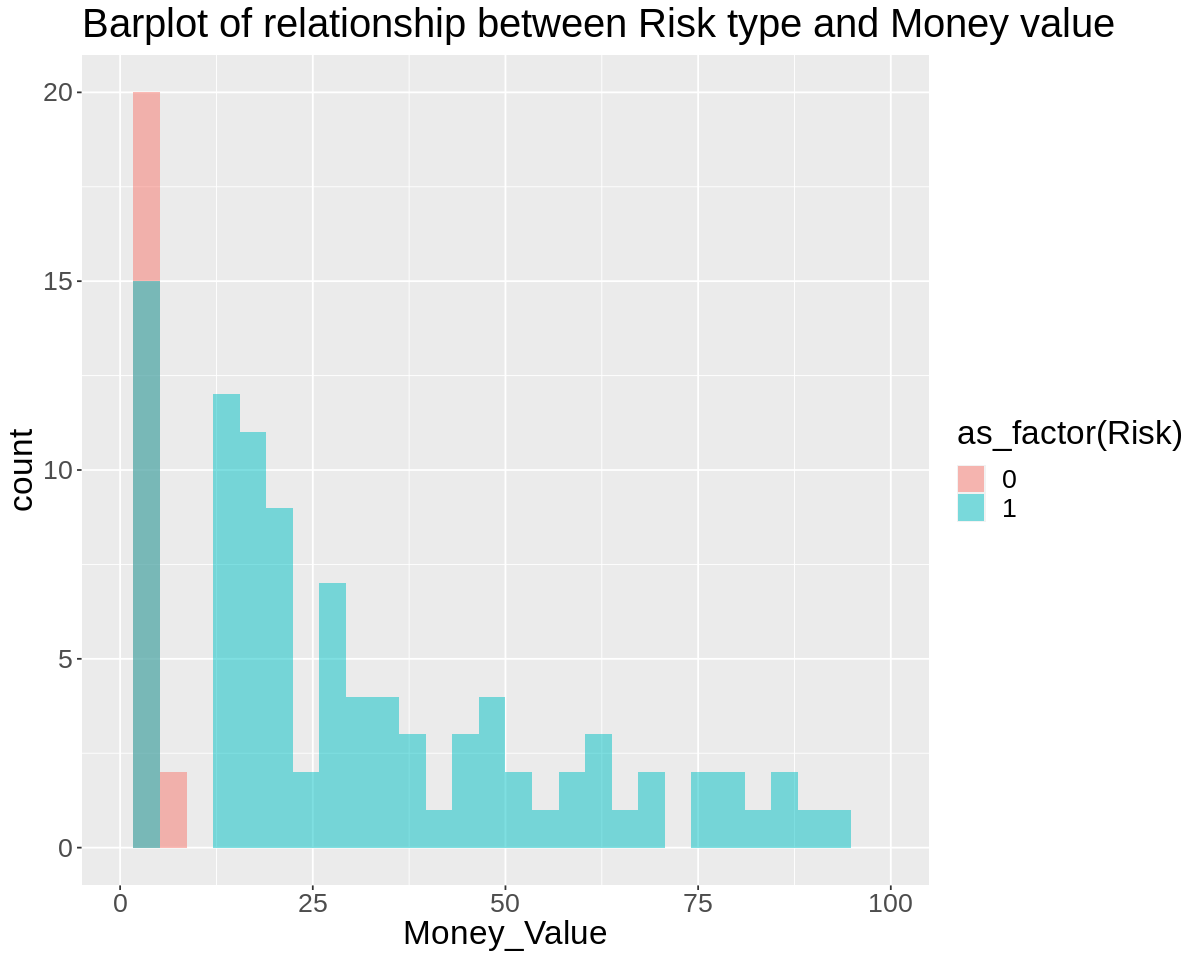

Warning message:
“Removed 103 rows containing missing values (geom_point).”


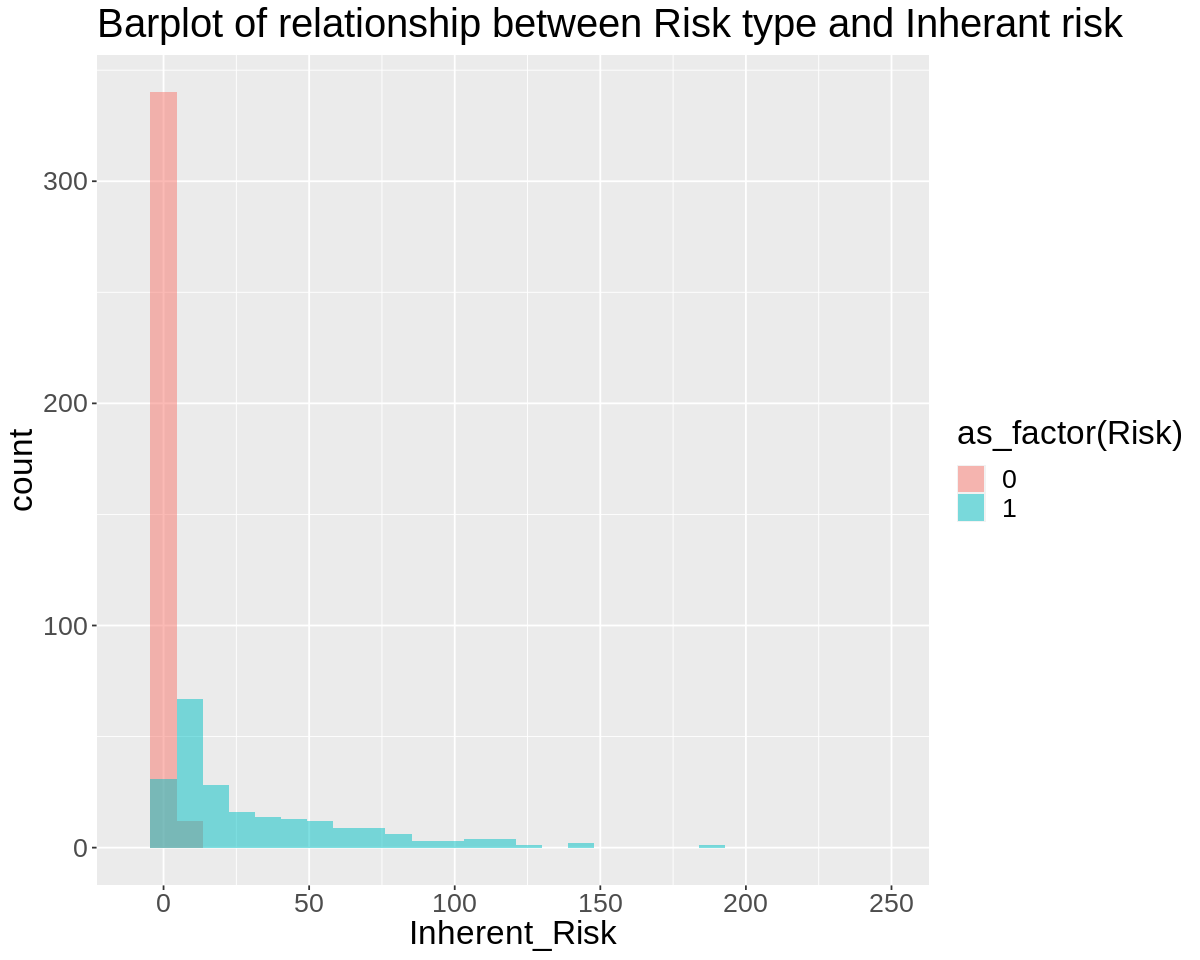

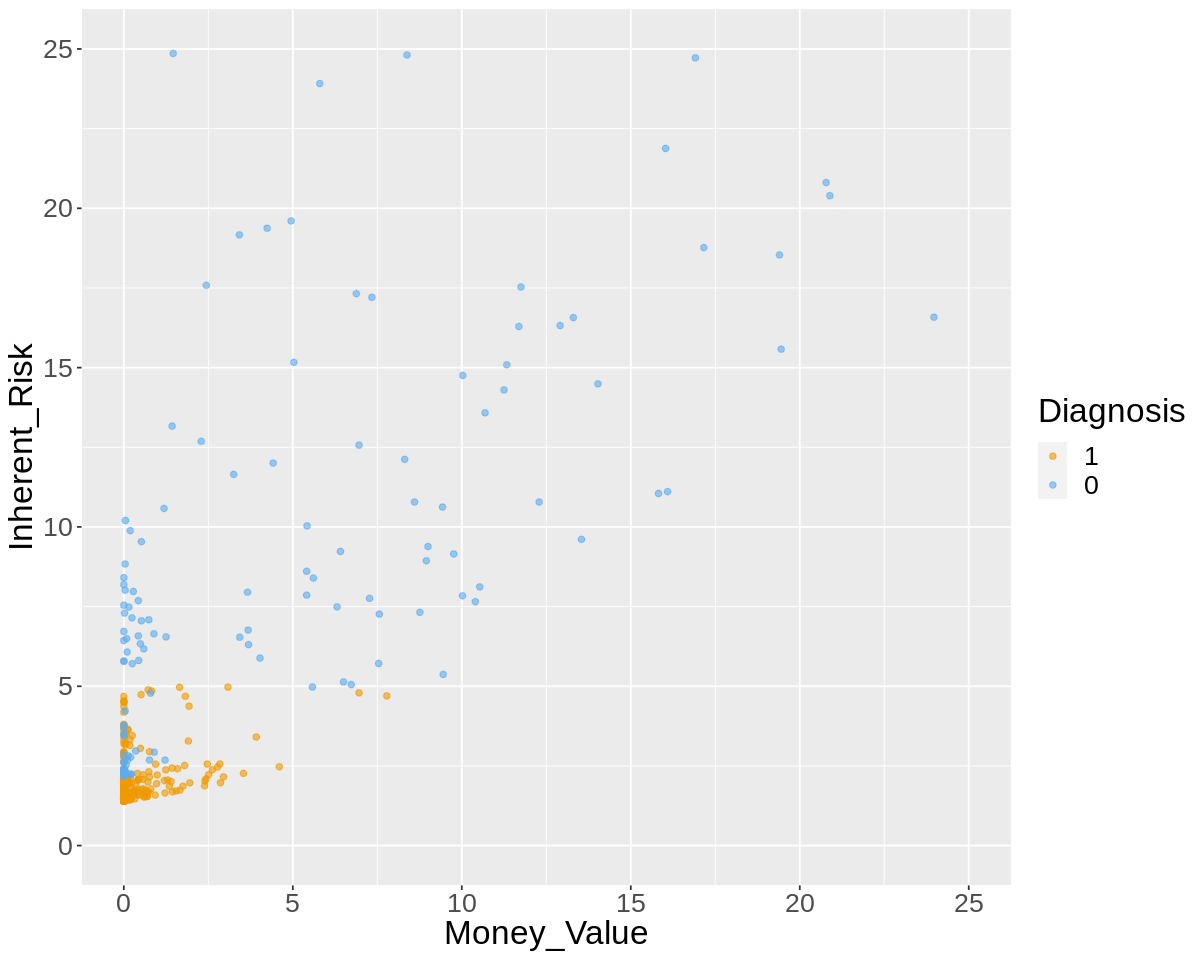

In [4]:
set.seed(2022)

audit_risk_train
# Number of observations
num_obs <- nrow(audit_risk_train)
num_obs

#Total number and percentage of different type of Risk
risk_sum <- audit_risk_train |>
group_by(Risk)|>
summarize(n = n(), precentage= n() / num_obs * 100) |>
arrange(desc(n))
risk_sum

#Mean value of all interest predictor variable 
summary <- audit_risk_train |>
group_by(Risk) |>
summarize(mean_sc = mean(Score, na.rm = TRUE),
          mean_mv = mean(Money_Value, na.rm = TRUE),
          mean_ir= mean(Inherent_Risk, na.rm = TRUE),
          mean_cr = mean(CONTROL_RISK, na.rm = TRUE),
          mean_dr = mean(Detection_Risk, na.rm = TRUE),
          mean_ar= mean(Audit_Risk, na.rm = TRUE))
summary

#Max and min value of the predictor variable (Money_Value)
Audit_Risk_mv <- summarize(audit_risk_train, mv_min = min(Money_Value, na.rm = TRUE),
                 mv_max = max(Money_Value, na.rm = TRUE))
Audit_Risk_mv

#Max and min value of the predictor variable (Inherent_Risk)
Audit_Risk_ir <- summarize(audit_risk_train, ir_min = min(Inherent_Risk, na.rm = TRUE),
                 ir_max = max(Inherent_Risk, na.rm = TRUE))
Audit_Risk_ir

options(repr.plot.width = 10, repr.plot.height = 8)

#Bar plot (Money_value)
audit_risk_mv <- ggplot(audit_risk_train, aes(x = Money_Value, fill = as_factor(Risk))) +
                          geom_histogram(alpha = 0.5, position = "identity") + 
xlim(0,100)+
ylim(0,20)+
ggtitle("Barplot of relationship between Risk type and Money value") + theme(text = element_text(size = 20)) 
audit_risk_mv

#Bar plot (Inherant_Risk)
audit_risk_ir <- ggplot(audit_risk_train, aes(x = Inherent_Risk, fill = as_factor(Risk))) +
                          geom_histogram(alpha = 0.5, position = "identity") + 
xlim(-10, 250)+
ggtitle("Barplot of relationship between Risk type and Inherant risk") + theme(text = element_text(size = 20)) 
audit_risk_ir

point_plot <- audit_risk_train |>
  ggplot(aes(x = Money_Value, y = Inherent_Risk, color = Risk)) +
  geom_point(alpha = 0.6) +
xlim(0,25)+
ylim(0,25)+
  labs(x = "Money_Value", 
       y = "Inherent_Risk",
       color = "Diagnosis") +
  scale_color_manual(labels = c("1", "0"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 20))
point_plot

## Methods

To begin, we will upload the dataset to GitHub and obtain a link that will allow us to read it into R using the `read_csv` function. We only select variables that are relevant to our analysis, which are "Audit Risk", "Score", "Money_Value", "Inherent Risk", "Control Risk", "Detection Risk", "Audit Risk" and "Risk", as explained in the introduction. Also, we would want to convert the character "Risk" variable to the factor datatype using `as_factor` to ensure the further coding is run correctly. A variable, ID, is added as the first column to specify and number each audit case.

In [5]:
set.seed(2022)

audit_risk<- read.csv("https://raw.githubusercontent.com/RofiaChen555/dsci-100-group-project/main/data/audit_risk.csv")
audit_risk

risk_dataset <- select(audit_risk, Score, Money_Value, Inherent_Risk, CONTROL_RISK, Detection_Risk, Audit_Risk, Risk)|>
            mutate(Risk = as_factor(Risk))

risk_dataset <- tibble::rowid_to_column(risk_dataset, "ID")            
            
risk_dataset

Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,0
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,0
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,0


ID,Score,Money_Value,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2.4,3.38,8.574,0.4,0.5,1.7148,1
2,2.0,0.94,2.554,0.4,0.5,0.5108,0
3,2.0,0.00,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
774,2,0.00,1.456,0.4,0.5,0.2912,0
775,2,0.00,1.440,0.4,0.5,0.2880,0
776,2,0.32,1.464,0.4,0.5,0.2928,0


In order to have a training set and a testing set, we will first need to use the `initial_split` function to split, shuffle, and stratify the data. We will set 
prop = 0.75 to ensure that 75% of our original data is split into the training set and also set the strata argument to the categorical variable, Risk, to let 
the training and testing sets include the correct proportions of each category of observation. Then, we can just apply the `training` and `testing` function to obtain the two subsets, and blank data will be filtered out.

In [6]:
set.seed(2022)
audit_risk_split <- initial_split(risk_dataset, prop = 0.75, strata = Risk)
audit_risk_train <- training(audit_risk_split)|>
                filter(!is.na(Money_Value))
audit_risk_test <- testing(audit_risk_split)|>
                filter(!is.na(Money_Value))

To construct a recipe, we will only use and standardize the training dataset to avoid influencing the testing dataset with any modelling or standardization.

In [7]:
set.seed(2022)

audit_risk_recipe<-recipe(Risk ~ Score + Money_Value + Inherent_Risk + CONTROL_RISK + Audit_Risk, data = audit_risk_train)|>
        step_scale(all_predictors())|>
        step_center(all_predictors())

audit_risk_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Then, we will create a model to train the classifier with only the training dataset. Since we are going to perform the cross-validation and are yet to find the K value, we will put `tune()` for `neighbors` instead of entering a specific value.

In [8]:
audit_risk_recipe

knn_tune<-nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
        set_engine("kknn")|>
        set_mode("classification")

knn_tune

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In order to determine the optimal value of K, cross-validation help us to calculate an accuracy for each value of K within a reasonable range. Rather than randomly splitting the data, using cross-validation allows each observation in the training dataset is to be used just once in a validation set. For example, a 5-fold cross-validation would require us to split out the training data into 5 chunks, then use 1 chunk as the validation set and combine the remaining 4 chunks as the training set.


The detailed steps are listed below:

1. We use `vfold_cv` function to split the training data into `v = 5` folds and set `strata = Risk` to ensure the training and validation subsets include the correct proportions of each category of observation.

2. We create the k_vals data frame with the neighbors variable containing values from 1 to 20 (stepping by 1) using the seq function. Then we pass that data frame to the grid argument of tune_grid.

3. Using the `seq` function, we build the `k_vals` data frame with the `neighbors` variable storing values from 1 to 20 (stepping by 1).

4. Then, we can develop a workflow that contains the `audit_risk_recipe` and the `knn_tune model`. `tune_grid` function is used to fit each value in `k_val` to the model. Finally, we will use collect_metrics to gather the mean and standard error of the classifier's validation accuracy across all folds and filter only . `metric == "accuracy"` since other values are not very useful for now.

5. For the last step of cross-validation, we can plot an `accuracy_versus_k` graph to determine which number of neighbors provides the highest accuracy in prediction.


The accuracy_versus_k plot below demonstrates that K = 7 or K = 8 will provide us with the highest estimated accuracy. We will use K = 7 for the subsequent prediction.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9740769,5,0.007293520,Preprocessor1_Model01
2,accuracy,binary,0.9740769,5,0.007293520,Preprocessor1_Model02
3,accuracy,binary,0.9775402,5,0.005254905,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,binary,0.9430404,5,0.01274804,Preprocessor1_Model18
19,accuracy,binary,0.9464592,5,0.01713134,Preprocessor1_Model19
20,accuracy,binary,0.9464592,5,0.01713134,Preprocessor1_Model20


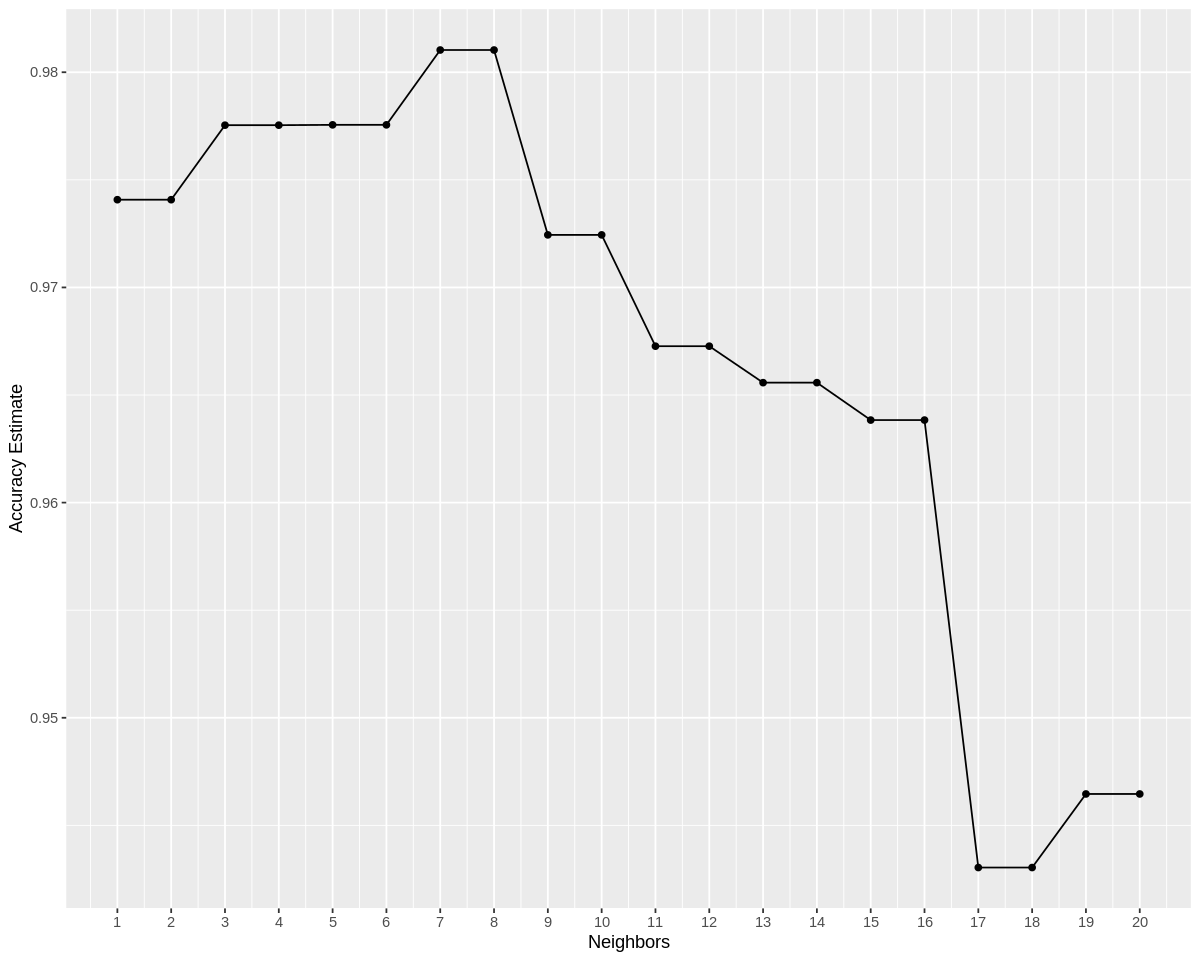

In [9]:
set.seed(2022)

audit_vfold<-vfold_cv(audit_risk_train, v = 5, strata = Risk)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

audit_result<-workflow()|>
        add_recipe(audit_risk_recipe)|>
        add_model(knn_tune)|>
        tune_grid(resamples = audit_vfold, grid = k_vals)|>                  
        collect_metrics()|>
        filter(.metric == "accuracy")

accuracy_versus_k<-ggplot(audit_result, aes(x=neighbors, y = mean))+
                    geom_point()+
                    geom_line()+
                    labs(x= "Neighbors", y = "Accuracy Estimate")+
                    scale_x_continuous(breaks = seq(0, 20, by = 1))

audit_result
accuracy_versus_k

The last step for the Methods part is to build a model. We will build the model specification with the best value for K, which is 7, as determined by the previous step, and then pass the best model specification and the training dataset to the `fit()` function. The recipe used can be the same as above.

Lastly, we will predict on the testing dataset using the best final model. We use the `bind_cols` to add the predictions column to the original testing dataset and specifying `truth = Risk` and `estimate = .pred_Class` to use the `metrics` function to display the quality of our model, which can be seen to be quite high (at roughly 98%), indicating that the predictors we used are reliable.

In [10]:
set.seed(2022)

knn_best<-nearest_neighbor(weight_func = "rectangular", neighbors = 7)|>
        set_engine("kknn")|>
        set_mode("classification")

audit_best_fit<-workflow()|>
            add_recipe(audit_risk_recipe)|>
            add_model(knn_best)|>
            fit(data = audit_risk_train)

audit_prediction<-predict(audit_best_fit, audit_risk_test)|>
            bind_cols(audit_risk_test)|>
            metrics(truth = Risk, estimate = .pred_class)|>
            filter(.metric == "accuracy")

audit_prediction

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9794872


## Expected outcomes and significance

It is expected that as money value increases, the risk of fraudulence increases proportionally. This finding can impact bigger corporations, as the more money a company has, the more likely fraudulent behaviour has occurred within the company. However, there are exceptions to this finding - there is a chance that companies with lower money value can still commit fraud. Moreover, it is expected that a company with a score over 2 would be considered fraudulent since score is used to predict risk. This would prompt more audits to occur in these bigger companies to further investigate the likelihood of fraud. To combat the high risk of fraud, how can we monitor these corporations so that fraud is reduced as money value increases? What can governing bodies do to ensure discrepancies in accounts do not go unnoticed? 
